Chain-Like System Natural Frequencies (Hz): [ 0.15915494  5.4173697  17.07344489]
Grounded System Natural Frequencies (Hz): [ 3.375899   12.79675207 18.66384806]


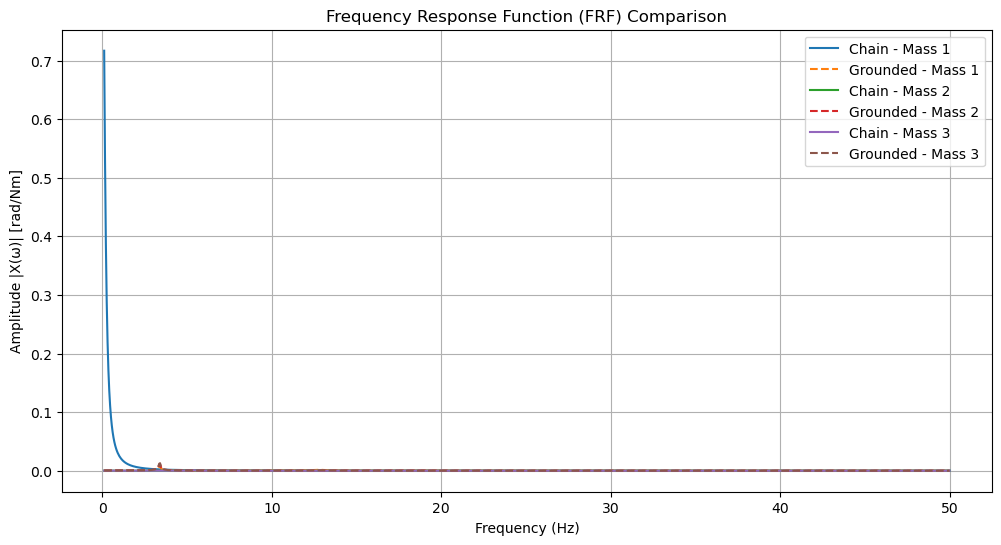

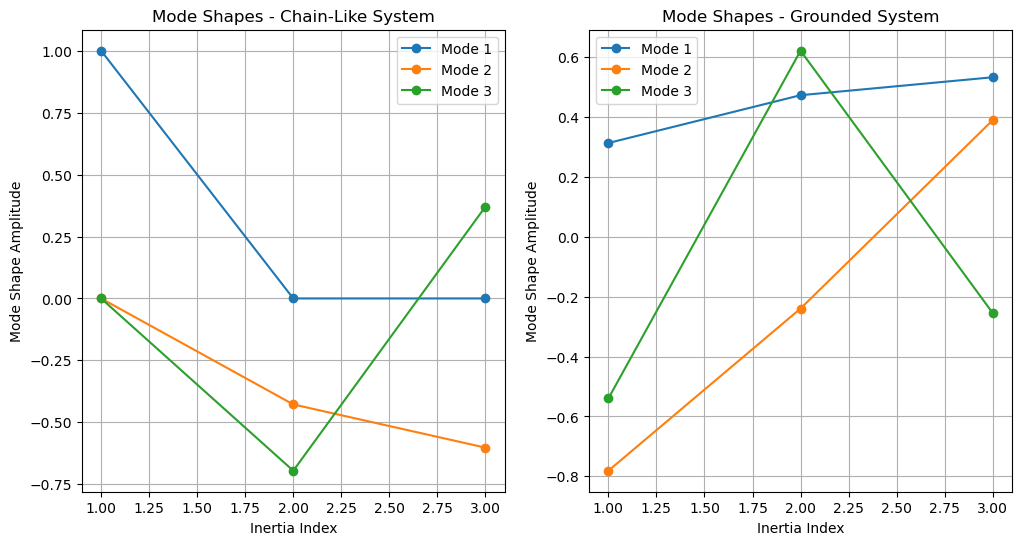

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# --------------------------------------------------------------------------------
# Define system properties (N-DOF system)
# --------------------------------------------------------------------------------
N_dof = 3  # Number of inertias

J = np.array([1.0, 1.5, 2.0])      # Inertias [kg.m²]
c = np.array([2.0, 3.0])           # Damping coefficients [N.m.s/rad]
k = np.array([5000.0, 8000.0])     # Torsional stiffness [N.m/rad]

# Extra stiffness/damping for the grounded case
k_ground = 3000.0  # Stiffness to ground at first inertia
c_ground = 5.0     # Damping to ground at first inertia

# Frequency range for analysis
f_vals = np.linspace(0.1, 50.0, 1000)
w_vals = 2 * np.pi * f_vals

# --------------------------------------------------------------------------------
# Function: Construct system matrices (Chain-Like)
# --------------------------------------------------------------------------------
def construct_chain_matrices(J, c, k, apply_constraint=True):
    """
    Constructs the mass, damping, and stiffness matrices for an N-DOF chain-like system.
    If apply_constraint=True, the first DOF is fixed to remove rigid-body motion.
    """
    N = len(J)
    M = np.diag(J)  # Mass matrix
    C = np.zeros((N, N))
    K = np.zeros((N, N))

    for i in range(N - 1):
        C[i, i] += c[i]
        C[i, i+1] = -c[i]
        C[i+1, i] = -c[i]
        C[i+1, i+1] += c[i]

        K[i, i] += k[i]
        K[i, i+1] = -k[i]
        K[i+1, i] = -k[i]
        K[i+1, i+1] += k[i]

    if apply_constraint:
        # Fix first DOF to eliminate rigid-body mode
        K[0, :] = 0
        K[:, 0] = 0
        K[0, 0] = 1  # Arbitrary large value to constrain first DOF

    return M, C, K

# --------------------------------------------------------------------------------
# Function: Construct system matrices (Grounded System)
# --------------------------------------------------------------------------------
def construct_grounded_matrices(J, c, k, k_ground, c_ground):
    """
    Constructs system matrices for an N-DOF system with an additional
    stiffness and damping to ground at the first inertia.
    """
    N = len(J)
    M, C, K = construct_chain_matrices(J, c, k, apply_constraint=False)

    # Add ground stiffness/damping at first DOF
    C[0, 0] += c_ground
    K[0, 0] += k_ground

    return M, C, K

# --------------------------------------------------------------------------------
# Function: Compute natural frequencies and mode shapes
# --------------------------------------------------------------------------------
def compute_modes(M, K):
    """
    Solves the eigenvalue problem for M * x'' + K * x = 0.
    Returns natural frequencies (Hz) and mode shapes.
    """
    eigvals, eigvecs = eigh(K, M)
    omega_n = np.sqrt(np.maximum(eigvals, 0))  # Ensure non-negative
    f_n = omega_n / (2 * np.pi)  # Convert to Hz
    return f_n, eigvecs

# --------------------------------------------------------------------------------
# Function: Compute frequency response (FRF)
# --------------------------------------------------------------------------------
def compute_FRF(M, C, K, w_vals, torque_loc=0):
    """
    Computes the frequency response function (FRF) at a given torque application location.
    Solves for X = (K - w^2 M + jwC)^(-1) * F.
    """
    N = M.shape[0]
    X_vals = np.zeros((N, len(w_vals)), dtype=complex)

    for i, w in enumerate(w_vals):
        A = K - w**2 * M + 1j * w * C  # Dynamic stiffness matrix
        F = np.zeros(N, dtype=complex)
        F[torque_loc] = 1.0  # Apply unit torque at torque_loc
        X_vals[:, i] = np.linalg.solve(A, F)

    return X_vals

# --------------------------------------------------------------------------------
# Compute Natural Frequencies
# --------------------------------------------------------------------------------
M_chain, C_chain, K_chain = construct_chain_matrices(J, c, k)
M_ground, C_ground, K_ground = construct_grounded_matrices(J, c, k, k_ground, c_ground)

f_n_chain, modes_chain = compute_modes(M_chain, K_chain)
f_n_ground, modes_ground = compute_modes(M_ground, K_ground)

print("Chain-Like System Natural Frequencies (Hz):", f_n_chain)
print("Grounded System Natural Frequencies (Hz):", f_n_ground)

# --------------------------------------------------------------------------------
# Compute Frequency Response Functions
# --------------------------------------------------------------------------------
X_chain = compute_FRF(M_chain, C_chain, K_chain, w_vals)
X_ground = compute_FRF(M_ground, C_ground, K_ground, w_vals)

# --------------------------------------------------------------------------------
# Plot Results: FRF Comparison
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

for i in range(N_dof):
    plt.plot(f_vals, np.abs(X_chain[i, :]), linestyle="solid", label=f'Chain - Mass {i+1}')
    plt.plot(f_vals, np.abs(X_ground[i, :]), linestyle="dashed", label=f'Grounded - Mass {i+1}')

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude |X(ω)| [rad/Nm]")
plt.title("Frequency Response Function (FRF) Comparison")
plt.legend()
plt.grid()
plt.show()

# --------------------------------------------------------------------------------
# Plot Results: Mode Shapes Comparison
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Chain-like mode shapes
for i in range(N_dof):
    ax[0].plot(range(1, N_dof + 1), modes_chain[:, i], marker="o", label=f"Mode {i+1}")
ax[0].set_title("Mode Shapes - Chain-Like System")
ax[0].set_xlabel("Inertia Index")
ax[0].set_ylabel("Mode Shape Amplitude")
ax[0].legend()
ax[0].grid()

# Grounded mode shapes
for i in range(N_dof):
    ax[1].plot(range(1, N_dof + 1), modes_ground[:, i], marker="o", label=f"Mode {i+1}")
ax[1].set_title("Mode Shapes - Grounded System")
ax[1].set_xlabel("Inertia Index")
ax[1].set_ylabel("Mode Shape Amplitude")
ax[1].legend()
ax[1].grid()

plt.show()
